In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Baseline1

In [2]:
import numpy as np
import cv2
import keras
from keras import regularizers
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import SGD
from keras.datasets import imdb
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import StratifiedKFold
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input

Using TensorFlow backend.
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the mo

## Import Features

In [3]:
def get_value(data):
    arr_row = []
    for i in range(len(data)):
        row = data[i]
        pt1 = row[1] + (row[3] - row[1])/2
        pt2 = row[2] + (row[4] - row[2])/2
        temp =[int(pt1), int(pt2)]
        arr_row.append(temp)
        
    return np.array(arr_row)
    

In [5]:
def get_features(folder):
    arr_X = []; arr_Y = []
    for i in range(112):
        
        filenameX = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/driver_features/visual/sample_"+str(i+1)+".npy"
        filenameY="/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
        if(os.path.exists(filenameX) and os.path.exists(filenameY)):
            x = np.load(filenameX)
            y = np.load(filenameY)

            if(x.shape[0]>=50):
                arr_X.append(x[:50,:])
                if(i>=9):
                    arr_Y.append(get_value(y[:50,:]))
                else: 
                    arr_Y.append(y[:50,:])

    
    return np.array(arr_X), np.array(arr_Y)

            
    

In [9]:
X1, Y1 = get_features(2)
X2, Y2 = get_features(3)
X3, Y3 = get_features(5)
X4, Y4 = get_features(7)
X5, Y5 = get_features(8)
X6, Y6 = get_features(10)
X7, Y7 = get_features(11)
X8, Y8 = get_features(12)
X9, Y9 = get_features(13)
X10, Y10 = get_features(14)


Xdata = np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10), axis = 0)
Ydata = np.concatenate((Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10), axis = 0)

print(Xdata.shape, Ydata.shape)

(1053, 50, 2622) (1053, 50, 2)


## Train, Val and Test Splitt

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test1, y_train, y_test1 = train_test_split(Xdata, Ydata, test_size=0.35)
X_val, X_test, y_val, y_test = train_test_split( X_test1, y_test1, test_size=0.5)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(684, 50, 2622) (684, 50, 2) (184, 50, 2622) (184, 50, 2) (185, 50, 2622) (185, 50, 2)


## Train the model

In [70]:
from keras.layers import TimeDistributed

model = Sequential()  
model.add(GRU(512, return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(GRU(250, return_sequences= True))
# model.add(GRU(250, return_sequences= True))
model.add(Dense(256))
model.add(Dense(64))
#kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.add(TimeDistributed(Dense(2)))
model.add(Activation('linear'))   
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 50, 512)           4815360   
_________________________________________________________________
dense_9 (Dense)              (None, 50, 256)           131328    
_________________________________________________________________
dense_10 (Dense)             (None, 50, 64)            16448     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 50, 2)             130       
_________________________________________________________________
activation_7 (Activation)    (None, 50, 2)             0         
Total params: 4,963,266
Trainable params: 4,963,266
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(loss='mse', optimizer='adam', metrics =['mae'])  

In [82]:
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =5, verbose =0, mode ='auto')
history = model.fit(X_train, y_train, epochs=300, batch_size=8, callbacks=[earlystopping],
        class_weight = 'balanced',validation_data=(X_val, y_val), verbose=2, shuffle= True)
print(history.history.keys())


Train on 684 samples, validate on 184 samples
Epoch 1/300
 - 6s - loss: 74182.7731 - mean_absolute_error: 202.7918 - val_loss: 59938.3364 - val_mean_absolute_error: 178.7722
Epoch 2/300
 - 5s - loss: 73275.2418 - mean_absolute_error: 200.7656 - val_loss: 59237.5651 - val_mean_absolute_error: 176.4563
Epoch 3/300
 - 5s - loss: 73236.5984 - mean_absolute_error: 199.3229 - val_loss: 61928.5378 - val_mean_absolute_error: 179.7320
Epoch 4/300
 - 5s - loss: 74301.9100 - mean_absolute_error: 200.8233 - val_loss: 59201.5653 - val_mean_absolute_error: 174.6161
Epoch 5/300
 - 5s - loss: 73211.9154 - mean_absolute_error: 198.1490 - val_loss: 59838.4226 - val_mean_absolute_error: 176.9781
Epoch 6/300
 - 5s - loss: 73419.3699 - mean_absolute_error: 200.1268 - val_loss: 64940.8331 - val_mean_absolute_error: 191.7137
Epoch 7/300
 - 5s - loss: 72285.2308 - mean_absolute_error: 199.1264 - val_loss: 60044.1527 - val_mean_absolute_error: 178.4868
Epoch 8/300
 - 5s - loss: 73809.5952 - mean_absolute_error

In [83]:
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'val_mean_absolute_error', 'mean_absolute_error'])


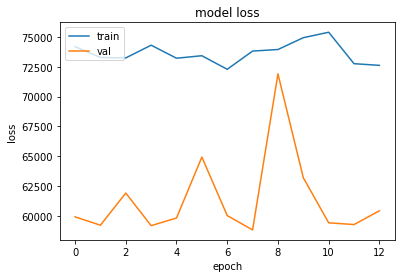

In [84]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['mean_absolute_error'])
# plt.plot(history.history['val_mean_absolute_error'])
# plt.title('model mean absoluteerror')
# plt.ylabel('mae')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

## Prediction on test dataset

In [85]:
def get_prediction(X_input):
    if(len(X_input.shape)<3):
        data = X_input.reshape(1, X_input.shape[0], X_input.shape[1])
    else:
        data = X_input
        
    test = model.predict(data)
   # print(test.shape)
    
    return test

In [86]:
for i in range(0,20):
    pred_y = get_prediction(X2[i])
    print(pred_y)
    print(np.concatenate((pred_y[0].astype(int), Y2[i]), axis =1))

[[[971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646

[[[971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646

[[[971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646.536  ]
  [971.03687 646